# Text Analytics - Assignment 1 (Salary Prediction)

## Nick Fleder, Bryan Lanier, Paige McKenzie, Aishwarya Srikanth, and Meyappan Subbaiah 

### Load Data

In [22]:
import pandas as pd
data_raw = pd.read_csv("Train_rev1.csv").sample(n=10000,random_state=1)
# data_raw.head()

In [23]:
data_sel = data_raw[["FullDescription","SalaryNormalized"]]
# data_sel.head()

### A1. What are the top 5 parts of speech in this corpus of job descriptions? How frequently do they appear?

The top five parts of speech are singular nouns, adjectives, prepositions, plural nouns, and determiners. The frequencies are displayed in the output.

In [24]:
# Define function to remove unnecessary characters from words

from nltk import pos_tag, word_tokenize
def remove_weird_char(string):
    import re
    string = string.lower()
    words = string.split()
    refined = []
    for i in words:
        refined.append(re.sub("[^\w]+", " ", i))
    sentence = ' '.join([word for word in refined])
    return(sentence)

In [25]:
# Define function to remove stopwords from given text

from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
def rmStopWords(text):
        text = ' '.join([word for word in text.split() if word not in cachedStopWords])
        return(text)

In [26]:
# Remove unnecessary characters from job descriptions

pd.options.mode.chained_assignment = None
data_sel["FullDescription"] = data_sel["FullDescription"].apply(remove_weird_char)

In [27]:
# Slice dataframe to get relevant column
job_desc = data_sel['FullDescription'].str.cat(sep=" ")

# Tokenize, tag, and turn into a dataframe
pos_df = pd.DataFrame(pos_tag(word_tokenize(job_desc)), columns = ['Word', 'POS'])
pos_df['POS'].value_counts()[:5]

NN     642103
JJ     285228
IN     261208
NNS    205464
DT     202514
Name: POS, dtype: int64

### A2. Does this corpus support Zipf’s law? Plot the most common 100 words in the corpus against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

Zipf's law states that given a large sample of words used, the frequency of any word is inversely proportional to its rank in the frequency table.

From the plot obtained, we see that the corpus supports this law.

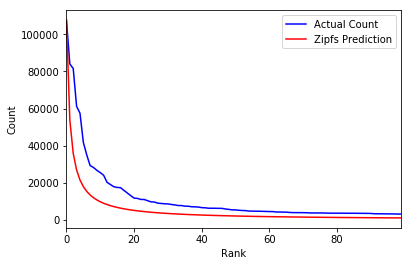

In [28]:
# Create dataframe of words and their corresponding frequencies

zipfs_df = pos_df["Word"].value_counts()[:100].to_frame().reset_index()
zipfs_df.columns = ["word","count"]

# Create column of predicted frequency by dividing max frequency by rank of each word
zipfs_df["predicted_values"] = max(zipfs_df["count"])/(zipfs_df.index+1)

# Plot rank against word frequency
import matplotlib.pyplot as plt
%matplotlib inline

fig = zipfs_df["count"].plot(color="blue",label="Actual Count")
fig = zipfs_df["predicted_values"].plot(color="red",label="Zipfs Prediction")
plt.xlabel("Rank")
plt.ylabel("Count")
fig.legend()
plt.show()

### A3. If we remove stopwords and lemmatize the corpus, what are the 10 most common words? What are their frequencies?

In [29]:
# Remove stopwords from job description
job_desc_clean = rmStopWords(job_desc)

In [30]:
# Define functions to return correct abbreviations of parts of speech

from nltk.corpus import wordnet as wn

def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']


def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return None

In [31]:
# Add 'wn' column with abbreviation for the part of speech

from nltk.stem import WordNetLemmatizer

job_desc_lem_df = pd.DataFrame(pos_tag(word_tokenize(job_desc_clean)), columns = ['Word', 'POS'])
job_desc_lem_df["wn"] = job_desc_lem_df["POS"].apply(penn_to_wn)

In [32]:
# Define function for lemmatization and apply to dataframe

def lem(row):
    lemma = WordNetLemmatizer()
    if(row[2] == None):
        return(lemma.lemmatize(row[0]))
    return(lemma.lemmatize(row[0],row[2]))

job_desc_lem_df["lem_word"] = job_desc_lem_df.apply(lem,axis=1)

In [33]:
# Generate 10 mosst common words and their frequencies

job_desc_lem_df["lem_word"].value_counts()[:10]

work          21109
experience    19437
role          12467
team          12360
client        11344
business      10836
service       10080
skill          9446
manager        8698
within         8627
Name: lem_word, dtype: int64

### B1. Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)? 

The classification model is 79.85% accurate

In [34]:
# Create target variable with 'high' and 'low' labels

import numpy as np

data_sel['target'] = np.where(data_sel['SalaryNormalized']>=data_sel["SalaryNormalized"].quantile(0.75), 'high', 'low')
# data_sel.head()

In [35]:
# Create Naive Bayes Multinomiak Classifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from operator import itemgetter
from sklearn.metrics import classification_report

vectorizer = CountVectorizer()

trainset_size = int(round(len(data_sel)*0.80))
X_train = data_sel["FullDescription"].iloc[1:trainset_size,]
y_train = data_sel["target"].iloc[1:trainset_size,]

X_test = data_sel["FullDescription"].iloc[trainset_size:,]
y_test = data_sel["target"].iloc[trainset_size:,]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [36]:
# Generate confusion matrix

print('The accuracy for this classifier is ' + str(metrics.accuracy_score(y_test, y_nb_predicted)))
metrics.confusion_matrix(y_test, y_nb_predicted)

The accuracy for this classifier is 0.7985


array([[ 361,  146],
       [ 257, 1236]])

### B2. Speculate before running the following analysis whether lemmatization would help improve the accuracy of classification. Now create a classification model after lemmatization. Did the classification accuracy increase relative to B1? Comment on your speculation versus the actual results you obtained. 


#### Speculation:
Higher paying jobs would have more complex words in the job description. Since these would be lemmatized to simple words, it is likely that the classification model will not be able to capture the words that are deterministic of a high paying job. Hence, lemmatization may not improve the accuracy of the classification. 

#### Results:
The accuracy decreased from 79.85% to 79.6%. This could be due to the reasons we speculated.

In [37]:
# Define lemmatization function

def sent_lem(sentence):
    lemma = WordNetLemmatizer()
    lem_words = [lemma.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else lemma.lemmatize(i) for i,j in pos_tag(word_tokenize(sentence))]
    return(' '.join(lem_words))

In [38]:
# Lemmatize job descriptions

data_sel["lem_desc"] = data_sel["FullDescription"].apply(sent_lem)

In [39]:
# Implement Multinomial classifier

vectorizer = CountVectorizer()

trainset_size = int(round(len(data_sel)*0.80))
X_train = data_sel["lem_desc"].iloc[1:trainset_size,]
y_train = data_sel["target"].iloc[1:trainset_size,]

X_test = data_sel["lem_desc"].iloc[trainset_size:,]
y_test = data_sel["target"].iloc[trainset_size:,]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [40]:
# Generate confusion matrix

print('The accuracy for this classifier is ' + str(metrics.accuracy_score(y_test, y_nb_predicted)))
metrics.confusion_matrix(y_test, y_nb_predicted)

The accuracy for this classifier is 0.796


array([[ 359,  148],
       [ 260, 1233]])

### B3. Now speculate whether stopwords removal from the original data would help increase the accuracy of the model. Take out the stopwords (but do not lemmatize), build a classification model and check the accuracy, and compare with that in B1 & B2.   


#### Speculation:
Removal of stopwords will increase the accuracy of the model, since the words pertinent to job descriptions will gain more importance and the classification will be more relevant to the features that actually describe high or low paying jobs.

#### Results:
Contrary to what we expected, classification accuracy decreased from 79.85% to 79.65% by removing stopwords. This may be due to the fact that removing an entire list of stopwords reduces the utility fed into training the model, it may be better to remove a portion of the stopwords.

In [41]:
# Remove stopwords from job descriptions

data_sel["noSW_desc"] = data_sel["FullDescription"].apply(rmStopWords)

In [42]:
# Implement Multinomial Classifier

vectorizer = CountVectorizer()

trainset_size = int(round(len(data_sel)*0.80))
X_train = data_sel["noSW_desc"].iloc[1:trainset_size,]
y_train = data_sel["target"].iloc[1:trainset_size,]

X_test = data_sel["noSW_desc"].iloc[trainset_size:,]
y_test = data_sel["target"].iloc[trainset_size:,]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [43]:
# Generate confusion matrix

print('The accuracy for this classifier is ' + str(metrics.accuracy_score(y_test, y_nb_predicted)))
metrics.confusion_matrix(y_test, y_nb_predicted)

The accuracy for this classifier is 0.7965


array([[ 373,  134],
       [ 273, 1220]])

### Show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary. 

In [50]:
# Get top 10 words that are most indicative of high salary

data_hi = data_sel.loc[data_sel["target"] == 'high']
data_low = data_sel.loc[data_sel['target'] == 'low']

vectorizer = CountVectorizer()

trainset_size = int(round(len(data_hi)*0.80))
X_train = data_hi["noSW_desc"].iloc[1:trainset_size,]
y_train = data_hi["target"].iloc[1:trainset_size,]

X_test = data_hi["noSW_desc"].iloc[trainset_size:,]
y_test = data_hi["target"].iloc[trainset_size:,]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
nb_classifier = MultinomialNB().fit(X_train, y_train)

N = 10
vocabulary = np.array([t for t, i in sorted(vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])
topN = np.argsort(nb_classifier.coef_[0])[-N:]
print("\nThe top %d most informative features for high salary: \n%s" % (N, " ".join(vocabulary[topN])))


The top 10 most informative features for high salary: 
manager client within skills work management team role business experience


In [51]:
# Get top 10 words descriptive of low salary

vectorizer = CountVectorizer()

trainset_size = int(round(len(data_low)*0.80))
X_train = data_low["noSW_desc"].iloc[1:trainset_size,]
y_train = data_low["target"].iloc[1:trainset_size,]

X_test = data_low["noSW_desc"].iloc[trainset_size:,]
y_test = data_low["target"].iloc[trainset_size:,]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
nb_classifier = MultinomialNB().fit(X_train, y_train)

vocabulary = np.array([t for t, i in sorted(vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])
topN = np.argsort(nb_classifier.coef_[0])[-N:]
print("\nThe top %d most informative features for low salary: \n%s" % (N, " ".join(vocabulary[topN])))


The top 10 most informative features for low salary: 
client within business working sales skills team role work experience


### B4.  Use the job descriptions without lemmatiztion and stopword removal. Add parts-of-speech bigrams to the bag-of-words, and run a new classification model. Does the accuracy increase over the results in B1?  

Adding parts-of-speech bigrams increases the accuracy of the classification model from 79.85% to 82.4%. This is expected as bigrams can capture sentiments more accurately than individual words.

In [52]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                     token_pattern=r'\b\w+\b', min_df=1)

In [53]:
trainset_size = int(round(len(data_sel)*0.80))
X = bigram_vectorizer.fit_transform(data_sel["FullDescription"])

X_train = X[1:trainset_size,]
y_train = data_sel["target"].iloc[1:trainset_size,]

X_test = X[trainset_size:,]
y_test = data_sel["target"].iloc[trainset_size:,]

In [54]:
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)
print('The accuracy for this classifier is ' + str(metrics.accuracy_score(y_test, y_nb_predicted)))
metrics.confusion_matrix(y_test, y_nb_predicted)

The accuracy for this classifier is 0.824


array([[ 278,  229],
       [ 123, 1370]])